In [ ]:
%load_ext autoreload
%autoreload 2

from src.sampling.main import stratified_spatial_sampling_dual
from dataset.weather_graph_dataset import WeatherGraphDataset

import torch
from torch_geometric.data import HeteroData
from src.raingauge.utils import (
    get_station_coordinate_mappings,
    load_weather_station_dataset,
)
import pandas as pd
import numpy as np
import networkx as nx
from sklearn.neighbors import NearestNeighbors
import tqdm
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import time
from scipy.stats import pearsonr
from src.radar.utils import load_radar_dataset
from src.visualization.main import pandas_to_geodataframe, visualise_singapore_outline
from src.visualization.radar import improved_visualise_radar_grid
from src.visualization.raingauge import visualise_gauge_grid
import cartopy.crs as ccrs
import matplotlib as mpl

In [ ]:
weather_station_data = load_weather_station_dataset('weather_station_data.csv')
weather_station_locations = get_station_coordinate_mappings()


In [ ]:
print(len(weather_station_locations.keys()))

In [ ]:
print(len(set(weather_station_data['gid'].values)))

# Preprocess station data.
Some stations only contain rainfall information but some stations contain both rainfall and other information.
We will split these stations into weather station and general stations 

Additional info: 
  Windspeed
  Wind Direction
  Temperature
  Relative Humidity

In [ ]:
cols = list(weather_station_data.columns)
cols.remove('time_sgt')
cols.remove('gid')

weather_station_df_pivot = pd.pivot(data=weather_station_data, index='time_sgt', columns='gid', values=cols).resample('15min').first()
weather_station_df_pivot['rain_rate'] = weather_station_df_pivot['rain_rate'] * 12
weather_station_df_counts = weather_station_df_pivot.count().reset_index()

weather_station_info = pd.pivot(data=weather_station_df_counts, index='gid', columns = 'level_0')

pd.set_option('display.max_rows', None)

rainfall_station = [row[0] for row in weather_station_info.iterrows() if 0 in row[1].value_counts()]
general_station = [s for s in weather_station_locations if s not in rainfall_station]

print(rainfall_station)
print(general_station)

In [ ]:
count = 0
for row in weather_station_df_pivot['rain_rate'].iterrows():
  if np.nansum(row[1].to_numpy()) != 0:
    count += 1
print(f"Number of timesteps that contain rain: {count}")
print(f"Total_timesteps = {weather_station_df_pivot.shape[0]}")


In [ ]:
pd.set_option('display.max_rows', 20)

general_station_data = {}
rainfall_station_data = {}
for station in weather_station_df_pivot.columns.get_level_values(1).unique():
    station_cols = weather_station_df_pivot.xs(station, level=1, axis=1).interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')
    if station in general_station:
      general_station_data[station] = station_cols.values
    else:
      rainfall_station_data[station] = station_cols.values[:, 0:1]


In [ ]:
general_station_temp = [stn for stn in general_station if stn != "S108"]
general_station = general_station_temp

In [ ]:
data = HeteroData()

general_station_features = []
rainfall_station_features = []
for station in general_station:
  station_feat = general_station_data[station]
  general_station_features.append(station_feat)

for station in rainfall_station:
  station_feat = rainfall_station_data[station]
  rainfall_station_features.append(station_feat)

dtype = torch.float32
data['general_station'].x = torch.tensor(np.array(general_station_features).transpose(1, 0, 2), dtype=dtype)
data['rainfall_station'].x = torch.tensor(np.array(rainfall_station_features).transpose(1,0,2), dtype=dtype)

data['general_station'].y = torch.tensor(np.array(general_station_features)[:,:,0:1].transpose(1,0,2), dtype=dtype)
data['rainfall_station'].y = torch.tensor(np.array(rainfall_station_features).transpose(1,0,2), dtype=dtype)

print(data)

In [ ]:
split_info = stratified_spatial_sampling_dual(weather_station_locations, seed=1111)
print(split_info)

data['general_station'].train_mask = [1 if station in split_info['ml']['train'] else 0 for station in general_station]
data['general_station'].val_mask = [1 if station in split_info['ml']['validation'] else 0 for station in general_station]
data['general_station'].test_mask = [1 if (x == 0 and y == 0) else 0 for x,y in zip(data['general_station'].train_mask, data['general_station'].val_mask)]

data['rainfall_station'].train_mask = [1 if station in split_info['ml']['train'] else 0 for station in rainfall_station]
data['rainfall_station'].val_mask = [1 if station in split_info['ml']['validation'] else 0 for station in rainfall_station]
data['rainfall_station'].test_mask = [1 if (x == 0 and y == 0) else 0 for x,y in zip(data['rainfall_station'].train_mask, data['rainfall_station'].val_mask)]

print(data)

# Edge generation
We consider the location of the stations when performing our edge generation. 
General station locations and rainfall station locations will be considered the same and we will make a connection across the nodes if required. This will ensure that we can connect both the layers together in the graph.

In [ ]:
import math
def get_distance(a, b):
  return math.sqrt((a[0] - b[0]) ** 2 + (a[1] - b[1]) ** 2 )

In [ ]:
#variable to determine number of neighbours per node
import networkx as nx
from sklearn.neighbors import NearestNeighbors
K = 4

ids = general_station + rainfall_station
print(ids)

coordinates = []
for id in ids:
  coordinates.append(weather_station_locations[id])
coords = np.array(coordinates)

print(coords)
knn = NearestNeighbors(n_neighbors=K+1, algorithm='ball_tree')
knn.fit(coords)

distances, indices = knn.kneighbors(coords)

G = nx.Graph()

edges = {
        'rainfall_to_rainfall': [],  
        'rainfall_to_general': [],    
        'general_to_rainfall': [],  
        'general_to_general': []      
    }

edge_attributes = {
        'rainfall_to_rainfall': [],  
        'rainfall_to_general': [],    
        'general_to_rainfall': [],  
        'general_to_general': []      
}

#add station coordinates for nx plotting
for idx, station in enumerate(general_station + rainfall_station):
  G.add_node(idx, pos=(weather_station_locations[station][1], weather_station_locations[station][0]))
color_map = ['green' for i in range(len(general_station))] + ['red' for i in range(len(rainfall_station))]

for idx, row in enumerate(indices):
  origin = row[0]
  
  for n in row[1:]: 
    G.add_edge(origin, n)
    if ids[origin] in rainfall_station:
      start_id = rainfall_station.index(ids[origin])
      if ids[n] in rainfall_station:
        end_id = rainfall_station.index(ids[n])
        edges['rainfall_to_rainfall'].append([start_id, end_id])
        edge_attributes['rainfall_to_rainfall'].append([get_distance(weather_station_locations[ids[origin]], weather_station_locations[ids[n]])])
      else:
        end_id = general_station.index(ids[n])
        edges['rainfall_to_general'].append([start_id, end_id])
        edge_attributes['rainfall_to_general'].append([get_distance(weather_station_locations[ids[origin]], weather_station_locations[ids[n]])])
    else:
      start_id = general_station.index(ids[origin])
      if ids[n] in rainfall_station:
        end_id = rainfall_station.index(ids[n])
        edges['general_to_rainfall'].append([start_id, end_id])
        edge_attributes['general_to_rainfall'].append([get_distance(weather_station_locations[ids[origin]], weather_station_locations[ids[n]])])
      else:
        end_id = general_station.index(ids[n])
        edges['general_to_general'].append([start_id, end_id])
        edge_attributes['general_to_general'].append([get_distance(weather_station_locations[ids[origin]], weather_station_locations[ids[n]])])

print(G)
print(len(list(nx.connected_components(G))))
nx.draw(G, nx.get_node_attributes(G, 'pos'), node_color = color_map, with_labels=True, font_weight='bold')

for key, val in edges.items():
  xarr = []
  yarr = []
  for x, y in val:
    xarr.append(x)
    yarr.append(y)
  edges[key] = [xarr, yarr]


data['general_station', 'gen_to_rain', 'rainfall_station'].edge_index = torch.tensor(edges['general_to_rainfall'], dtype=torch.int64)
data['rainfall_station', 'rain_to_gen', 'general_station'].edge_index = torch.tensor(edges['rainfall_to_general'], dtype=torch.int64)
data['general_station', 'gen_to_gen', 'general_station'].edge_index = torch.tensor(edges['general_to_general'], dtype=torch.int64)
data['rainfall_station', 'rain_to_rain', 'rainfall_station'].edge_index = torch.tensor(edges['rainfall_to_rainfall'], dtype=torch.int64)

data['general_station', 'gen_to_rain', 'rainfall_station'].edge_attr = torch.tensor(edge_attributes['general_to_rainfall'], dtype=torch.float32)
data['rainfall_station', 'rain_to_gen', 'general_station'].edge_attr = torch.tensor(edge_attributes['rainfall_to_general'], dtype=torch.float32)
data['general_station', 'gen_to_gen', 'general_station'].edge_attr = torch.tensor(edge_attributes['general_to_general'], dtype=torch.float32)
data['rainfall_station', 'rain_to_rain', 'rainfall_station'].edge_attr = torch.tensor(edge_attributes['rainfall_to_rainfall'], dtype=torch.float32)

print(data)

In [ ]:
print(len(edge_attributes['rainfall_to_rainfall']))

In [ ]:
#Process edge indices
print(data)
print(data.edge_types)



In [ ]:
print(data['general_station', 'gen_to_rain', 'rainfall_station'].edge_attr) 
print(data['rainfall_station', 'rain_to_gen', 'general_station'].edge_index) 
print(data['general_station', 'gen_to_gen', 'general_station'].edge_index) 
print(len(set(data['rainfall_station', 'rain_to_rain', 'rainfall_station'].edge_index.detach().numpy()[0])) )


In [ ]:
print(data.has_isolated_nodes())
print(data.has_self_loops())
print(data.is_undirected())

In [ ]:
print(data['general_station', 'gen_to_rain', 'rainfall_station']['edge_index'])

# Creating the GNN

In [ ]:
from models.gnn import HeteroGNN, HeteroGNN2, HeteroSAGEGNN, HeteroGCNGNN

model = HeteroGNN2(hidden_channels=4, out_channels=1,
                  num_layers=5)

model.to(device='cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
import tqdm
import torch.nn.functional as F
def collate_temporal_graphs(batch):
  gen_x = torch.stack([item['gen_x'] for item in batch])
  rain_x = torch.stack([item['rain_x'] for item in batch])
  gen_y = torch.stack([item['gen_y'] for item in batch])
  rain_y = torch.stack([item['rain_y'] for item in batch])

  metastation_mask = batch[0]['metastation_mask']
  rainfallstation_mask = batch[0]['rainfallstation_mask']
  edge_index_dict = batch[0]['edge_index_dict']
  edge_attribute_dict = batch[0]['edge_attr_dict']

  return {
      'gen_x': gen_x,
      'rain_x': rain_x,
      'gen_y': gen_y,
      'rain_y': rain_y,
      'metastation_mask': metastation_mask,
      'rainfallstation_mask': rainfallstation_mask,
      'edge_index_dict': edge_index_dict,
      'edge_attr_dict': edge_attribute_dict
  }

def train_epoch(model, data, dataloader, optimizer, device):  
  model.train()
  losses = []

  charge_bar = tqdm.tqdm(dataloader, desc='training')
  '''
  This is fake batching... AI suggested doing it before I realised it did nothing...
  Currently a lot of copying of data structure. Might be able to do optimization with this.
  '''
  for batch in charge_bar:
      # reset gradients
      optimizer.zero_grad()

      edge_index_dict = batch["edge_index_dict"]
      edge_attribute_dict = batch["edge_attr_dict"]

      for i in range(batch['gen_x'].shape[0]):

          train_metastation_mask = torch.tensor(batch['metastation_mask'], dtype=torch.bool).to(device)
          train_rainfallstation_mask = torch.tensor(batch['rainfallstation_mask'], dtype=torch.bool).to(device)
          step_loss = []

          training_metastation_indices = train_metastation_mask.nonzero(as_tuple=False)
          training_rainfallstation_indices = train_rainfallstation_mask.nonzero(as_tuple=False)
          gen_x = batch['gen_x']  # [batch_size, num_gen_nodes, gen_features]
          rain_x = batch['rain_x']  # [batch_size, num_rain_nodes, rain_features]
          gen_y = batch['gen_y']
          rain_y = batch['rain_y']

          #Start by indiviually masking metastations
          for idx in training_metastation_indices:
              gen_x_masked=gen_x[i].clone()
              rain_x_masked=rain_x[i].clone()
      
              gen_x_masked[~train_metastation_mask.bool()] = 0
              rain_x_masked[~train_rainfallstation_mask.bool()] = 0
              gen_x_masked[idx] = 0

              x_dict = {
              'general_station': gen_x_masked,
              'rainfall_station': rain_x_masked,
              }
              optimizer.zero_grad()
              out = model(x_dict, edge_index_dict, edge_attribute_dict)

              # Model prediction
              gen_predictions = out['general_station'][idx]
              gen_actual = gen_y[i][idx]

              training_loss = F.mse_loss(gen_predictions, gen_actual) 
              step_loss.append(training_loss)

          #Indiviually mask rain stations
          for idx in training_rainfallstation_indices:
              gen_x_masked=gen_x[i].clone()
              rain_x_masked=rain_x[i].clone()
      
              #Mask stations that are not training stations
              gen_x_masked[~train_metastation_mask.bool()] = 0
              rain_x_masked[~train_rainfallstation_mask.bool()] = 0
              #Mask the selected rainfall station
              rain_x_masked[idx] = 0

              x_dict = {
              'general_station': gen_x_masked,
              'rainfall_station': rain_x_masked,
              }
              optimizer.zero_grad()
              out = model(x_dict, edge_index_dict, edge_attribute_dict)

              # Model prediction
              rain_predictions = out['rainfall_station'][idx]
              rainfall_actual = rain_y[i][idx]

              training_loss = F.mse_loss(rain_predictions, rainfall_actual)
              step_loss.append(training_loss)
          
          loss = torch.stack(step_loss).mean()
          losses.append(loss.detach())

          #backpropagate
          loss.backward()

          # Update weights
          optimizer.step()


  losses = torch.stack(losses).mean().item()

  return losses


'''
Below is the code for the sampling method if we wanna use it later
'''
# def train_epoch(model, data, dataloader, optimizer, device):
#   model.train()
#   total_training_loss = 0

#   train_gen_mask = torch.tensor(data['general_station'].train_mask, dtype=torch.bool).to(device)
#   train_rain_mask = torch.tensor(data['rainfall_station'].train_mask, dtype=torch.bool).to(device)

#   test_gen_mask = torch.tensor(data['general_station'].test_mask, dtype=torch.bool).to(device)
#   test_rain_mask = torch.tensor(data['rainfall_station'].test_mask, dtype=torch.bool).to(device)

#   val_gen_mask = torch.tensor(data['general_station'].val_mask, dtype=torch.bool).to(device)
#   val_rain_mask = torch.tensor(data['rainfall_station'].val_mask, dtype=torch.bool).to(device)

#   edge_index_dict = {
#     key:val.to(device) for key, val in data.edge_index_dict.items()
#   }

#   edge_attribute_dict = {
#     key:val.to(device) for key, val in data.edge_attr_dict.items()
#   }
#   for batch in tqdm.tqdm(dataloader, desc="training"):
#     gen_x = batch['gen_x'].to(device)  # [batch_size, num_gen_nodes, gen_features]
#     rain_x = batch['rain_x'].to(device)  # [batch_size, num_rain_nodes, rain_features]
#     gen_y = batch['gen_y'].to(device)
#     rain_y = batch['rain_y'].to(device)

#     batch_size = gen_x.shape[0]

#     batch_loss = 0.0
#     count = 0
#     for i in range(batch_size):
#       training_metastation_indices = train_gen_mask.nonzero(as_tuple=False)
#       training_rainfallstation_indices = train_rain_mask.nonzero(as_tuple=False)
#       sampling_ratio = 0.8

#       for idx in range(5):
#         # Create mask for the stations whose values we want to predict and not use as input
#         # Sampling is done instead of training node by node just to make it train through epochs faster        
#         samples = math.floor((training_metastation_indices.numel() + training_rainfallstation_indices.numel()) * sampling_ratio)
#         mask_positions = torch.randperm(training_metastation_indices.numel() + training_rainfallstation_indices.numel())[0:samples]
#         metastation_indices = training_metastation_indices[mask_positions[mask_positions < training_metastation_indices.numel()]].flatten()
#         rainfallstation_indices = training_rainfallstation_indices[mask_positions[mask_positions >= training_metastation_indices.numel()] - training_metastation_indices.numel()].flatten()

#         gen_x_masked=gen_x[i].clone()
#         rain_x_masked=rain_x[i].clone()
  
#         gen_x_masked[val_gen_mask] = 0
#         rain_x_masked[val_rain_mask] = 0
#         gen_x_masked[test_gen_mask] = 0
#         rain_x_masked[test_rain_mask] = 0
#         gen_x_masked[metastation_indices] = 0
#         rain_x_masked[rainfallstation_indices] = 0

#         x_dict = {
#           'general_station': gen_x_masked,
#           'rainfall_station': rain_x_masked,
#         }
#         # print(x_dict)
#         optimizer.zero_grad()
#         out = model(x_dict, edge_index_dict, edge_attribute_dict)


#         gen_predictions = out['general_station'][metastation_indices]
#         rain_predictions = out['rainfall_station'][rainfallstation_indices]
#         gen_actual = gen_y[i][metastation_indices]
#         rainfall_actual = rain_y[i][rainfallstation_indices]

#         #Deals with case that all station of one type is masked and tensor is [] causing nan
#         if metastation_indices.numel() == 0:
#           gen_predictions = torch.zeros(1, device=device)
#           gen_actual= torch.zeros(1, device=device)
#         if rainfallstation_indices.numel() == 0:
#           rain_predictions = torch.zeros(1, device=device)
#           rainfall_actual = torch.zeros(1, device=device)
          

#         training_loss = F.mse_loss(gen_predictions, gen_actual) + F.mse_loss(rain_predictions, rainfall_actual)
#         batch_loss += training_loss
#         count += rain_predictions.numel() + gen_predictions.numel()

#     batch_loss = batch_loss / count
#     batch_loss.backward()
#     optimizer.step()
#     total_training_loss += batch_loss.item()
 
#   return total_training_loss/len(dataloader)


In [ ]:
def validate(model, data, dataloader, device):
  total_validation_loss = 0

  val_gen_mask = torch.tensor(data['general_station'].val_mask, dtype=torch.bool).to(device)
  val_rain_mask = torch.tensor(data['rainfall_station'].val_mask, dtype=torch.bool).to(device)
  test_gen_mask = torch.tensor(data['general_station'].test_mask, dtype=torch.bool).to(device)
  test_rain_mask = torch.tensor(data['rainfall_station'].test_mask, dtype=torch.bool).to(device)
  train_gen_mask = torch.tensor(data['general_station'].train_mask, dtype=torch.bool).to(device)
  train_rain_mask = torch.tensor(data['rainfall_station'].train_mask, dtype=torch.bool).to(device)

  edge_index_dict = {
    key:val.to(device) for key, val in data.edge_index_dict.items()
  }
  edge_attr_dict = {
    key:val.to(device) for key, val in data.edge_attr_dict.items()
  }
  for batch in tqdm.tqdm(dataloader, desc="validation"):
    gen_x = batch['gen_x'].to(device)  # [batch_size, num_gen_nodes, gen_features]
    rain_x = batch['rain_x'].to(device)  # [batch_size, num_rain_nodes, rain_features]
    gen_y = batch['gen_y'].to(device)
    rain_y = batch['rain_y'].to(device)

    batch_size = gen_x.shape[0]

    batch_loss = 0
    for i in range(batch_size):
      gen_x_masked=gen_x[i].clone()
      rain_x_masked=rain_x[i].clone()

      gen_x_masked[test_gen_mask] = 0
      rain_x_masked[test_rain_mask] = 0
      gen_x_masked[train_gen_mask] = 0
      rain_x_masked[train_rain_mask] = 0
      x_dict = {
        'general_station': gen_x_masked,
        'rainfall_station': rain_x_masked
      }
      out = model(x_dict, edge_index_dict, edge_attr_dict)


      gen_predictions = out['general_station'][val_gen_mask]
      rain_predictions = out['rainfall_station'][val_rain_mask]


      validation_loss = F.mse_loss(gen_predictions, gen_y[i][val_gen_mask]) + F.mse_loss(rain_predictions, rain_y[i][val_rain_mask])
      
  
      batch_loss += validation_loss.item()
    total_validation_loss += batch_loss
 
  return total_validation_loss/len(dataloader)

In [21]:
import torch
import torch.nn.functional as F
import random 
import tqdm as tqdm
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import time

#set seeds
seed=123
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)


batch_size=16
train_dataset = WeatherGraphDataset(data, mode='train')
val_dataset = WeatherGraphDataset(data, mode='val')
device = 'cuda' if torch.cuda.is_available() else 'cpu'

train_loader = DataLoader(
  train_dataset,
  batch_size=batch_size,
  shuffle=False,
  collate_fn=collate_temporal_graphs
)
test_loader = DataLoader(
  val_dataset,
  batch_size=batch_size,
  shuffle=False,
  collate_fn=collate_temporal_graphs
)

optimizer=torch.optim.Adam(model.parameters(), lr=0.001)
training_loss_arr = []
validation_loss_arr = []
early = 0
mini = 1000
stopping_condition = 5
epochs=0

training_start = time.time()
for i in range(20):
  print(f'-----EPOCH: {i + 1}-----')
  train_loss = train_epoch(model, data, train_loader, optimizer, device)
  validation_loss = validate(model, data, test_loader, device)
  training_loss_arr.append(train_loss)
  validation_loss_arr.append(validation_loss)
  if mini >= validation_loss:
    mini = validation_loss
    early = 0
  else:
    early += 1
  epochs+=1
  if early >= stopping_condition:
    print("Early stop loss")
    break

  print(f"Train Loss: {train_loss:.4f}")
  print(f"Validation Loss: {validation_loss:.4f}")

training_end = time.time()

print(f"Training took {training_end - training_start} seconds over {epochs} epochs")
plt.plot(training_loss_arr, label='training_loss', color='blue')
plt.plot(validation_loss_arr, label='validation_loss', color='red')
plt.legend()


validation: 100%|██████████| 546/546 [00:35<00:00, 15.45it/s]


Train Loss: 11.3348
Validation Loss: 314.3675
-----EPOCH: 2-----


validation: 100%|██████████| 546/546 [00:36<00:00, 14.84it/s]


Train Loss: 9.9915
Validation Loss: 304.3825
-----EPOCH: 3-----


validation: 100%|██████████| 546/546 [00:33<00:00, 16.10it/s]


Train Loss: 9.7137
Validation Loss: 291.1006
-----EPOCH: 4-----


validation: 100%|██████████| 546/546 [00:34<00:00, 15.97it/s]


Train Loss: 9.5713
Validation Loss: 267.3552
-----EPOCH: 5-----


validation: 100%|██████████| 546/546 [00:36<00:00, 14.97it/s]


Train Loss: 9.4170
Validation Loss: 296.1156
-----EPOCH: 6-----


validation: 100%|██████████| 546/546 [00:35<00:00, 15.60it/s]


Train Loss: 9.2880
Validation Loss: 279.6191
-----EPOCH: 7-----


training:   1%|          | 4/546 [00:27<1:02:08,  6.88s/it]


KeyboardInterrupt: 

In [22]:
print(next(iter(test_loader))['gen_x'].shape)

torch.Size([16, 15, 5])


In [23]:
total_params = sum(param.numel() for param in model.parameters())
print(total_params)
print(list(param for param in model.parameters()))



858
[Parameter containing:
tensor([[[ 0.3776, -0.2419, -0.5865,  0.0973]]], requires_grad=True), Parameter containing:
tensor([[[ 1.0539, -0.6409, -0.6901, -0.6703]]], requires_grad=True), Parameter containing:
tensor([ 2.2956,  1.3808,  0.0000, -0.2074], requires_grad=True), Parameter containing:
tensor([[-0.4735,  0.4016, -0.7263,  0.3698, -0.6781],
        [-1.5733,  0.1610,  0.5151, -0.2241,  0.0759],
        [-0.7048, -0.9019, -0.6623, -0.3474, -0.8022],
        [ 0.8512, -0.0139,  0.3836,  0.0563, -0.2018]], requires_grad=True), Parameter containing:
tensor([[ 0.2086,  0.8874, -0.2698,  0.3030, -0.2341],
        [ 0.5906,  0.5394, -0.8596,  0.6474,  0.2544],
        [ 0.3641,  0.2280,  0.5750, -0.1512, -0.8235],
        [-0.2234, -0.6821, -0.0483, -0.1981, -0.5712]], requires_grad=True), Parameter containing:
tensor([[[-0.3447,  0.3561, -1.1757, -0.0461]]], requires_grad=True), Parameter containing:
tensor([[[-0.5287,  0.8591,  0.6698,  0.7379]]], requires_grad=True), Parameter c

In [24]:
from scipy.stats import pearsonr

def test_model():
  model.eval()
  total_rmse = 0

  plot_preds = np.array([])
  plot_actual = np.array([])

  test_dataset = WeatherGraphDataset(data, mode='val')

  val_gen_mask = torch.tensor(data['general_station'].val_mask, dtype=torch.bool).to(device)
  val_rain_mask = torch.tensor([0 for _ in data['rainfall_station'].val_mask], dtype=torch.bool).to(device)
  test_gen_mask = torch.tensor(data['general_station'].test_mask, dtype=torch.bool).to(device)
  test_rain_mask = torch.tensor(data['rainfall_station'].test_mask, dtype=torch.bool).to(device)
  train_gen_mask = torch.tensor(data['general_station'].train_mask, dtype=torch.bool).to(device)
  train_rain_mask = torch.tensor(data['rainfall_station'].train_mask, dtype=torch.bool).to(device)

  print(test_gen_mask)

  edge_index_dict = {
    key:val.to(device) for key, val in data.edge_index_dict.items()
  }

  edge_attr_dict = {
    key:val.to(device) for key, val in data.edge_attr_dict.items()
  }

  dataloader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    collate_fn=collate_temporal_graphs
  )

  count = 0
  with torch.no_grad():
    for batch in tqdm.tqdm(dataloader, desc="testing"):
      gen_x = batch['gen_x'].to(device)  # [batch_size, num_gen_nodes, gen_features]
      rain_x = batch['rain_x'].to(device)  # [batch_size, num_rain_nodes, rain_features]
      gen_y = batch['gen_y'].to(device)
      rain_y = batch['rain_y'].to(device)

      batch_size = gen_x.shape[0]

      batch_rmse = 0
      for i in range(batch_size):

        gen_x_masked=gen_x[i].clone()
        rain_x_masked=rain_x[i].clone()

        gen_x_masked[val_gen_mask] = 0
        rain_x_masked[val_rain_mask] = 0
        gen_x_masked[test_gen_mask] = 0
        rain_x_masked[test_rain_mask] = 0
        x_dict = {
          'general_station': gen_x_masked,
          'rainfall_station': rain_x_masked
        }

        out = model(x_dict, edge_index_dict, edge_attr_dict)

        gen_predictions = out['general_station'][train_gen_mask]
        rain_predictions = out['rainfall_station'][train_rain_mask]

        gen_targets = gen_y[i][train_gen_mask]
        rain_targets = rain_y[i][train_rain_mask]

        plot_preds = np.concatenate((plot_preds, gen_predictions.detach().numpy().flatten(), rain_predictions.detach().numpy().flatten()))
        plot_actual = np.concatenate((plot_actual, gen_targets.detach().numpy().flatten(), rain_targets.detach().numpy().flatten()))

        gen_MSE_arr = (gen_predictions - gen_targets) ** 2
        rain_MSE_arr = (rain_predictions - rain_targets) ** 2

        all_squared_errors = torch.cat([gen_MSE_arr, rain_MSE_arr])
        test_rmse = torch.sqrt(torch.mean(all_squared_errors))

        batch_rmse += test_rmse.item()
        count += 1

      total_rmse += batch_rmse
 
  plt.scatter(x=plot_actual, y=plot_preds)
  plot_bound = max(np.nanmax(plot_actual).astype(int),np.nanmax(plot_preds).astype(int))
  plt.plot(np.linspace(0,plot_bound,100),
            np.linspace(0,plot_bound,100))
  plt.xlabel("actual rainfall")
  plt.ylabel("predicted rainfall")

  mask = ~np.isnan(plot_actual)
  pearson_r_global, pearson_p_global = pearsonr(plot_actual[mask], plot_preds[mask])

  print(f"Pearson correlation: {pearson_r_global}")
  return total_rmse/count

tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False])


testing: 100%|██████████| 8736/8736 [00:31<00:00, 278.42it/s]


Pearson correlation: 0.5646569967818486
TEST RMSE: 1.6390015473879274


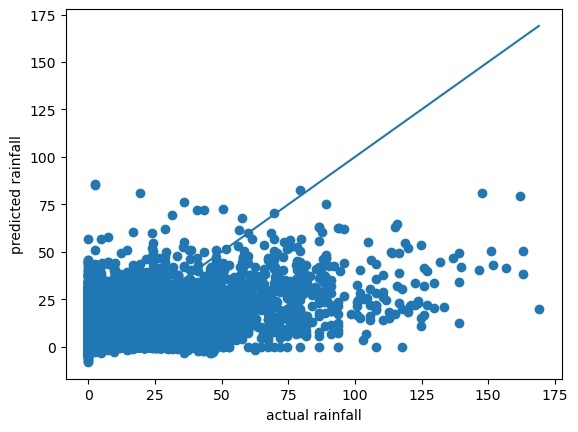

In [25]:
RMSE = test_model()
print(f"TEST RMSE: {RMSE}")

# Visualisation of output
Test event will be 02-05-2025 0415 to 0615


In [ ]:
test_event_data = weather_station_df_pivot.iloc[593:602]
print(test_event_data)
test_data = data.clone()

test_general_station_data = {}
test_rainfall_station_data = {}

for station in test_event_data.columns.get_level_values(1).unique():
    station_cols = test_event_data.xs(station, level=1, axis=1).interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')
    if station in general_station:
      test_general_station_data[station] = station_cols.values 
    else:
      test_rainfall_station_data[station] = station_cols.values[:, 0:1]
# print(test_general_station_data)
# print(test_rainfall_station_data)

test_general_station_features = []
test_rainfall_station_features = []

for station in general_station:
  if station in test_general_station_data:
    station_feat = test_general_station_data[station]
    test_general_station_features.append(station_feat)

for station in rainfall_station:
  if station in test_rainfall_station_data:
    station_feat = test_rainfall_station_data[station]
    test_rainfall_station_features.append(station_feat)

# print(test_general_station_features)
# print(test_rainfall_station_features)

test_data['general_station'].x = torch.tensor(np.array(test_general_station_features).transpose(1,0,2), dtype=torch.float)
test_data['general_station'].y = torch.tensor(np.array(test_general_station_features)[:, :,0:1].transpose(1,0,2), dtype=torch.float)
test_data['rainfall_station'].x = torch.tensor(np.array(test_rainfall_station_features).transpose(1,0,2), dtype=torch.float) 
test_data['rainfall_station'].y = torch.tensor(np.array(test_rainfall_station_features).transpose(1,0,2), dtype=torch.float)  

out = model(test_data.x_dict, test_data.edge_index_dict, test_data.edge_attr_dict)
gen_out = out['general_station'].detach().numpy()
rain_out = out['rainfall_station'].detach().numpy()

out_np = np.concatenate([gen_out, rain_out], axis=1)

In [ ]:
print(test_data.edge_index_dict)

# Visualise rain on radar grid
Hard coded to plot only consequitive 9 timestamps

In [ ]:
print(out_np / 12)

In [ ]:
from src.utils import *
from src.visualisation import *
radar_df = load_radar_dataset('radar_vis')

fig, ax = plt.subplots(3,3, figsize=(15,12), subplot_kw={'projection' : ccrs.PlateCarree()})

bounds_singapore = {
  'left': 103.6,
  'right': 104.1,
  'top': 1.5,
  'bottom': 1.188
}
bounds = [0.1, 0.2, 0.5, 1, 2, 4, 7, 10, 20] 
norm = mpl.colors.BoundaryNorm(boundaries=bounds, ncolors=256, extend='both')

out_np = out_np / 12
for idx, timestamp in enumerate(out_np):
  output = {}
  count = 0
  
  for stn in general_station:
    output[stn] = float(timestamp[count])
    count += 1
  for stn in rainfall_station:
    output[stn] = float(timestamp[count])
    count += 1
  axi = ax[idx // 3][idx % 3]
  node_df = pd.Series(output)
  node_df = pandas_to_geodataframe(node_df)
  visualise_gauge_grid(node_df=node_df, ax=axi)
  improved_visualise_radar_grid(radar_df.iloc[idx], ax=axi, zoom=bounds_singapore, norm=norm)
  visualise_singapore_outline(ax=axi)

In [ ]:
original_rainfall_rates = weather_station_df_pivot.iloc[1773:1797].resample('15min').first()['rain_rate']


print(original_rainfall_rates)

In [ ]:
print(out)

In [ ]:
actual_arr = []
pred_arr = []

for idx, timestamp in enumerate(out):
  output = {}
  count = 0
  a_arr = []
  p_arr = []
  
  for stn in general_station:
    output[stn] = float(timestamp[count])
    count += 1
  for stn in rainfall_station:
    output[stn] = float(timestamp[count])
    count += 1

  for key, value in output.items():
    a_arr.append(original_rainfall_rates.iloc[idx][key])
    p_arr.append(output[key])
  a_arr = list(map(lambda x: float(x), a_arr))
  actual_arr.append(a_arr)
  pred_arr.append(p_arr)

actual_arr = np.array(actual_arr)
pred_arr = np.array(pred_arr)

print(actual_arr)
print(pred_arr)
error = []
for i in range(len(actual_arr)):
  error.append(np.nanmean(actual_arr - pred_arr) ** 2)

MSE = np.mean(np.array(error))
print(MSE)


In [ ]:
print(original_rainfall_rates.iloc[0])